In [70]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

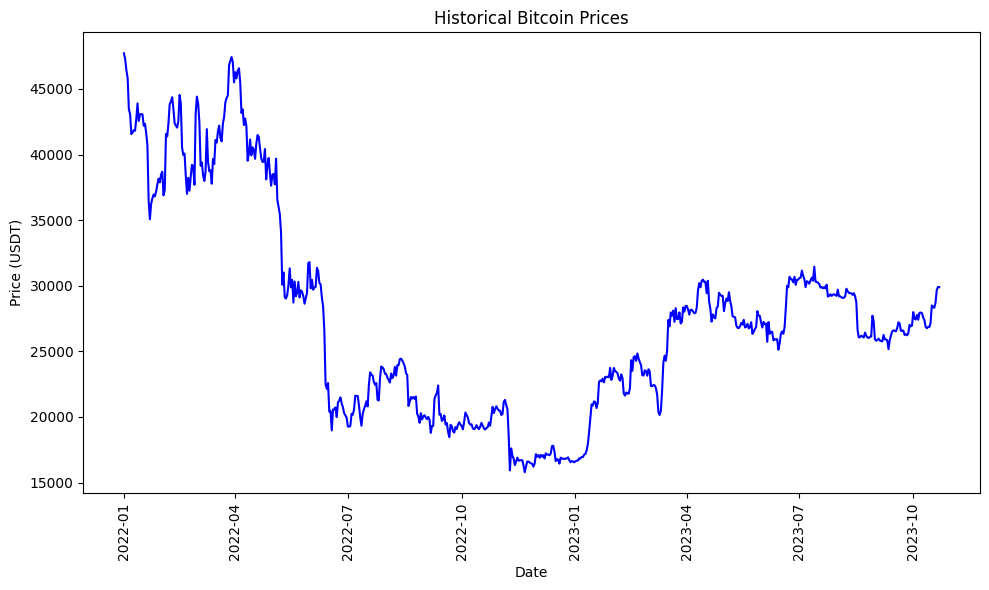

In [94]:
# Binance API endpoint for historical klines (candlestick) data
BASE_URL = "https://api.binance.com/api/v1/klines"

# Specify the symbol (BTCUSDT for Bitcoin to USDT)
symbol = "BTCUSDT"

# Specify the interval (1d for daily data)
interval = "1d"

# Convert dates to milliseconds since Unix epoch
start_date = pd.to_datetime("2022-01-01").timestamp() * 1000
end_date = pd.to_datetime("2023-10-22").timestamp() * 1000

# Parameters for the API request
params = {
    "symbol": symbol,
    "interval": interval,
    "startTime": int(start_date),
    "endTime": int(end_date),
    "limit": 1000  # Maximum number of data points per request (1000 is the maximum limit)
}

# Make the API request
response = requests.get(BASE_URL, params=params)

# Parse the JSON response
data = response.json()

# Extracting the timestamp and closing price from the response
timestamps = [entry[0] for entry in data]
prices = [float(entry[4]) for entry in data]

# Create a DataFrame for the data
df = pd.DataFrame({
    "Timestamp": timestamps,
    "Price": prices
})

# Convert timestamps to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# Print the DataFrame with historical Bitcoin prices
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Price'], linestyle='-', color='b')
plt.title('Historical Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.xticks(rotation='vertical')  # Display dates vertically
plt.tight_layout()
plt.show()

In [115]:
# we create training data for an LSTM using a window size
X, y = [], []
min_max = MinMaxScaler()
window = 20
np_prices = np.expand_dims(np.array(prices), axis=-1)
prices_train = min_max.fit_transform(np_prices[:int(len(np_prices)*0.8)])
for i in range(window,int(len(timestamps)*0.8)) : 
    X.append(prices_train[i-window:i])
    y.append(prices_train[i])
X_train, y_train = np.array(X), np.array(y)

In [135]:
print(X_train.shape)
print(y_train.shape)

(508, 20, 1)
(508, 1)


In [118]:
# create validation data
X, y = [], []
window = 20
min_max
prices_val = min_max.transform(np_prices[int(len(np_prices)*0.8):])
concatenation = np.concatenate((prices_train, prices_val), axis=0)
for i in range(int(len(timestamps)*0.8),len(timestamps)) : 
    X.append(concatenation[i-window:i])
    y.append(concatenation[i])
X_val, y_val = np.array(X), np.array(y)

In [119]:
print(X_val.shape)
print(y_val.shape)

(132, 20, 1)
(132, 1)


In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=[20, 1], return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 60)                26640     
                                                                 
 dense_6 (Dense)             (None, 10)                610       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 37661 (147.11 KB)
Trainable params: 37661 (147.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanSquaredError())

In [56]:
model.fit(X_train, y_train, epochs=100, batch_size=8)

Epoch 1/100
64/64 [==============================] - 3s 8ms/step - loss: 0.0200
Epoch 2/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 3/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 4/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 5/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 6/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 7/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 8/100
64/64 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 9/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 10/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 11/100
64/64 [==============================] - 1s 8ms/step - loss: 0.0026
Epoch 12/100
64/64 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 13/100
64/64 [=================

5/5 [==============================] - 0s 3ms/step
(508, 1)
640
528


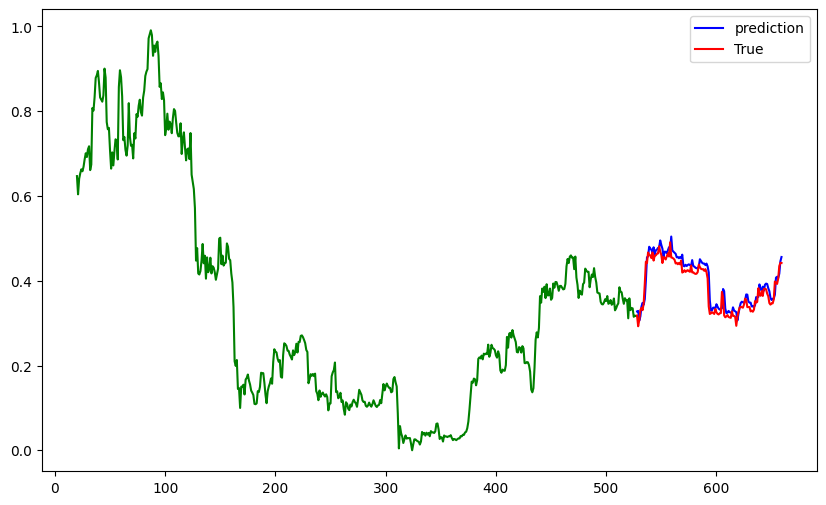

In [142]:
predictions = model.predict(X_val)
x = np.linspace(window,len(prices)-1, len(prices)-window)
plt.figure(figsize=(10, 6))
plt.plot(x[:int(len(prices)*0.8)-window],y_train, color='g')
plt.plot(x[int(len(prices)*0.8)-window:],predictions, linestyle='-', color='b', label="prediction")
plt.plot(x[int(len(prices)*0.8)-window:],y_val, linestyle='-', color='r', label="True")
plt.legend()
plt.show()